# ***Import Libraries***

In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from source.engine.FTP_engine import FTPModel as FTP

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 100000

C:\Users\capoma\AppData\Local\Temp\ipykernel_9944\877008696.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


# ***Load Data***

## ***Data Modelo***

In [3]:
path = "outputs/"
file = "output_sugerido_39.xlsx"

df = pd.read_excel(path + file, converters={'id_embarcacion':str})

name_fecha = 'fecha_produccion'
df.loc[:, name_fecha] = pd.to_datetime(
            df.loc[:, name_fecha], format="%Y/%m/%d"
        )
# df['y-m'] = df[name_fecha].apply(lambda x: '{0}-{1}'.format(x.year, x.isocalendar()[1]))

name_tempo = 'temporada'


df[name_tempo] =  pd.Categorical(
            df[name_tempo],
            ['2018-I', '2018-II', '2019-I', '2019-II', '2020-I', '2020-II', '2021-I', '2021-II'],
        )

df.loc[df['planta'].isna(), 'planta'] = 'Planta NA'

df.head()

Unnamed: 0    CBOD        Embarc Ind Propiedad  Orden_de_Prioridad   Tipo Tr Zona de Pesca       planta sort_tipo_embarc fecha_produccion id_embarcacion  volumen temporada  zona_de_pesca_id  flag_dia_adicional Prioridad 1 Prioridad 2 Prioridad 3 Prioridad 4 Prioridad 5 Prioridad 6 Prioridad 7 Prioridad 8 planta_sugerida  flag_termino
0           0  388.94       COQUI X       Tercera                   2  Terceros       Pisco S    PISCO SUR      3 Exclusivo       2018-04-07          28225   38.980    2018-I                14                   0     Pisco S     Pisco N         NaN         NaN         NaN         NaN         NaN         NaN         Pisco S             0
1           1  353.77     COQUI XII       Tercera                   3  Terceros       Pisco S    PISCO SUR      3 Exclusivo       2018-04-07          11074   41.950    2018-I                14                   0     Pisco S     Pisco N         NaN         NaN         NaN         NaN         NaN         NaN         Pisco S             0
2           2  339.00  SAN JUDAS II       Tercera                   5  Terceros       Pisco N  PISCO NORTE      3 Exclusivo       2018-04-07          41816  219.020    2018-I                13                   0     Pisco N     Pisco S         NaN         NaN         NaN         NaN         NaN         NaN         Pisco N             0
3           3  335.08      COQUI IX       Tercera                   6  Terceros       Pisco S    PISCO SUR      3 Exclusivo       2018-04-07          11071   33.375    2018-I                14                   0     Pisco S     Pisco N         NaN         NaN         NaN         NaN         NaN         NaN         Pisco S             0
4           4  296.85     MACABI 10       Tercera                  11  Terceros      Chimbote     CHIMBOTE      3 Exclusivo       2018-04-07          29416   31.935    2018-I                 3                   0    Chimbote     Samanco         NaN         NaN         NaN         NaN         NaN         NaN        Chimbote             0

## ***Flags***

In [4]:
# Flag tiene planta sugerida
mask_plant_notna = (df['planta_sugerida'].notna())

# Flag días de pesca adicionales
mask_adicional = (df['flag_dia_adicional'] == 1)

# Flag barcos de TASA
mask_prop = (df['Ind Propiedad'] == 'Propia')

# Flag término de temporada con días de pesca adicional
mask_fin_tempor = (df['flag_termino'] == 1)

mask_model = mask_plant_notna & ~mask_fin_tempor

### ***Modelo***

## ***Consideraciones***

1. Aparecen Nan debido a los registros creados de pesca adicional (no tienen porqué hacer match ya que fueron creados.)
   
2. Aparecen 'MATARANI' y 'ATICO' debido a que los registros creados de pesca adicional hacen match con pesca real que se tuvo en otras plantas.


## ***Volumen global Real (TASA + Terceros)***

In [5]:
vol_all = pd.pivot_table(df[~mask_adicional].groupby(['temporada', 'planta'], as_index=False)['volumen'].sum(), 
columns='temporada', values='volumen', index='planta' )
vol_all

temporada        2018-I     2018-II      2019-I    2019-II      2020-I     2020-II      2021-I     2021-II
planta                                                                                                    
CALLAO       113990.055   62736.004   71999.195  22565.690  124247.640   59569.690   90926.835  116230.735
CHIMBOTE     164052.120  104236.470   87257.615  78619.170  132157.555  131029.260  161053.097   67813.415
MALABRIGO    116768.140   57380.145  133311.605  59253.300  129001.400  155901.315  119162.780   60620.745
PISCO NORTE   28510.315   29200.510   21230.660      0.000       0.000       0.000       0.000       0.000
PISCO SUR     70667.420   45720.110   46989.655   1058.145       0.000   25100.645   32111.040   47928.455
SAMANCO       42702.875   31183.115   18335.130  20395.165    6421.975   36818.870   37443.405   17884.560
SUPE          67618.005   38474.650   20560.810  18434.970       0.000   44397.455   17422.920   38286.985
VEGUETA      107672.745   63116.655   33003.045  31033.935  100004.180   66255.870   58068.650   64684.325

## ***Volumen TASA Real (propios)***

In [6]:
vol_tasa_real = pd.pivot_table(df[mask_prop & ~mask_adicional].groupby(['temporada', 'planta'], as_index=False, dropna=False)['volumen'].sum(), 
columns='temporada', values='volumen', index='planta')

temp = vol_tasa_real.head(1).copy()
temp.index = ['Planta NA']
temp.loc[:, :] = 0.0
vol_tasa_real = pd.concat([vol_tasa_real, temp], ignore_index=False)

vol_tasa_real

temporada       2018-I    2018-II      2019-I    2019-II      2020-I    2020-II      2021-I    2021-II
CALLAO       77743.820  49174.269   38377.295  20941.065  101145.625  44859.720   67095.860  92543.600
CHIMBOTE     57144.055  50568.990   44104.270  28243.420   85068.795  89920.010  103822.972   8394.250
MALABRIGO    99856.895  28508.595  101133.545  28857.035   62612.935  51735.475   61058.855  35361.915
PISCO NORTE  27255.265  26487.940   18511.485      0.000       0.000      0.000       0.000      0.000
PISCO SUR    64101.565  42611.060   41514.800   1058.145       0.000  22629.305   28062.745  47670.045
SAMANCO      21277.255  20560.640   10373.370  14309.925    5835.890  31475.040   36388.480   3824.745
SUPE         46361.590  34678.560   18246.160  10282.950       0.000  42072.170   17422.920  37298.785
VEGUETA      75879.820  44748.780   25163.310  20772.760   74437.790  41359.580   35620.045  50939.535
Planta NA        0.000      0.000       0.000      0.000       0.000      0.000       0.000      0.000

In [7]:
vol_tasa_real.sum(axis=0)

temporada
2018-I     469620.265
2018-II    297338.834
2019-I     297424.235
2019-II    124465.300
2020-I     329101.035
2020-II    324051.300
2021-I     349471.877
2021-II    276032.875
dtype: float64

## ***Volumen Real Terceros***

In [8]:
vol_terceros = pd.pivot_table(df[(~mask_prop) & (~mask_adicional)].groupby(['temporada', 'planta'], as_index=False)['volumen'].sum(), 
columns='temporada', values='volumen', index='planta')
vol_terceros

temporada        2018-I    2018-II     2019-I    2019-II     2020-I     2020-II     2021-I    2021-II
planta                                                                                               
CALLAO        36246.235  13561.735  33621.900   1624.625  23102.015   14709.970  23830.975  23687.135
CHIMBOTE     106908.065  53667.480  43153.345  50375.750  47088.760   41109.250  57230.125  59419.165
MALABRIGO     16911.245  28871.550  32178.060  30396.265  66388.465  104165.840  58103.925  25258.830
PISCO NORTE    1255.050   2712.570   2719.175      0.000      0.000       0.000      0.000      0.000
PISCO SUR      6565.855   3109.050   5474.855      0.000      0.000    2471.340   4048.295    258.410
SAMANCO       21425.620  10622.475   7961.760   6085.240    586.085    5343.830   1054.925  14059.815
SUPE          21256.415   3796.090   2314.650   8152.020      0.000    2325.285      0.000    988.200
VEGUETA       31792.925  18367.875   7839.735  10261.175  25566.390   24896.290  22448.605  13744.790

In [9]:
vol_terceros.sum(axis=0)

temporada
2018-I     242361.410
2018-II    134708.825
2019-I     135263.480
2019-II    106895.075
2020-I     162731.715
2020-II    195021.805
2021-I     166716.850
2021-II    137416.345
dtype: float64

## ***Volumen Modelo (All)***

In [10]:
vol_model = pd.pivot_table(df[mask_model].groupby(['temporada', 'planta'], as_index=False, dropna=False)['volumen'].sum(), 
columns='temporada', values='volumen', index='planta', dropna=False, aggfunc=np.sum)
vol_model

temporada           2018-I       2018-II         2019-I       2019-II         2020-I        2020-II         2021-I        2021-II
planta                                                                                                                           
CALLAO       107267.545000  60949.334000   70003.485000  22565.690000  122086.000000   58259.090000   89585.495000  102194.965000
CHIMBOTE     150112.095000  87899.875000   85437.085000  74548.630000  127580.920000  130194.175000  153126.922000   67635.755000
MALABRIGO    115698.245000  55365.265000  126130.340000  51307.945000  110687.335000  153599.710000  116721.230000   60620.745000
PISCO NORTE   27541.600000  27434.735000   21230.660000      0.000000       0.000000       0.000000       0.000000       0.000000
PISCO SUR     62292.670000  44154.040000   46796.120000   1058.145000       0.000000   25100.645000   31900.185000   45040.950000
Planta NA     10684.256157  21480.819716    4599.132229   4288.317072   18227.896148    2243.842979   12074.262205   16485.888317
SAMANCO       42498.955000  27298.455000   18335.130000  20395.165000    6421.975000   36818.870000   36225.680000   17884.560000
SUPE          67213.445000  38474.650000   20560.810000  18283.915000       0.000000   44397.455000   17422.920000   38286.985000
VEGUETA      102713.375000  62640.550000   32593.675000  30373.535000   97152.945000   65557.975000   55610.580000   64684.325000

In [11]:
vol_model.sum(axis=0)

temporada
2018-I     686022.186157
2018-II    425697.723716
2019-I     425686.437229
2019-II    222821.342072
2020-I     482157.071148
2020-II    516171.762979
2021-I     512667.274205
2021-II    412834.173317
dtype: float64

## ***Volumen TASA Modelo***

In [12]:
vol_model_tasa = pd.pivot_table(df[mask_model & mask_prop].groupby(['temporada', 'planta'], as_index=False, dropna=False)['volumen'].sum(), 
columns='temporada', values='volumen', index='planta', dropna=False, aggfunc=np.sum)
vol_model_tasa

temporada          2018-I       2018-II        2019-I       2019-II        2020-I       2020-II        2021-I       2021-II
planta                                                                                                                     
CALLAO       76856.125000  48192.984000  38377.295000  20941.065000  98983.985000  43643.680000  67006.000000  78872.065000
CHIMBOTE     54555.695000  38699.090000  43750.690000  27284.325000  82407.695000  89349.135000  95951.287000   8394.250000
MALABRIGO    99856.895000  27325.255000  97204.640000  25488.725000  50724.820000  51685.305000  60170.660000  35361.915000
PISCO NORTE  26908.825000  24722.165000  18511.485000      0.000000      0.000000      0.000000      0.000000      0.000000
PISCO SUR    59950.680000  41044.990000  41321.265000   1058.145000      0.000000  22629.305000  28062.745000  44782.540000
Planta NA    10684.256157  21480.819716   4599.132229   4288.317072  18227.896148   2243.842979  12074.262205  16485.888317
SAMANCO      21277.255000  16755.300000  10373.370000  14309.925000   5835.890000  31475.040000  35170.755000   3824.745000
SUPE         46057.035000  34678.560000  18246.160000  10282.950000      0.000000  42072.170000  17422.920000  37298.785000
VEGUETA      73401.195000  44424.240000  24945.470000  20772.760000  72886.495000  40939.600000  33504.215000  50939.535000

## ***Diferencia Tasa VS Model***

In [13]:
(vol_tasa_real - vol_model_tasa).sum(axis=0)

temporada
2018-I      72.303843
2018-II     15.430284
2019-I      94.727771
2019-II     39.087928
2020-I      34.253852
2020-II     13.222021
2021-I     109.032795
2021-II     73.151683
dtype: float64

<center><font face="Times" size="10px" color="#FFFFF0">Conversión del Modelo a Dinero</font></center>

## ***MP Descargada Propios***

In [14]:
mp_descargado_propios = pd.pivot_table(df[mask_model & mask_prop].groupby(['temporada', 'planta_sugerida'], as_index=False, dropna=False)['volumen'].sum(), 
columns='temporada', values='volumen', index='planta_sugerida', dropna=False, aggfunc=np.sum)
mp_descargado_propios

temporada              2018-I       2018-II         2019-I       2019-II        2020-I        2020-II         2021-I       2021-II
planta_sugerida                                                                                                                   
Callao           87019.665000  58654.590903   48714.041106  15110.210619  87826.991175   40262.695000   62841.262290  80522.649936
Chimbote         91973.497674  59274.366285   42853.139202  40958.968827  97287.933710  103473.960413   88679.078178  15150.001410
Malabrigo        82784.648300  47901.617112  114296.585694  31302.884253  77560.191816   81755.057566  101614.161773  39432.684947
Pisco N          14133.810000  12152.145000    6762.005000      0.000000      0.000000       0.000000       0.000000      0.000000
Pisco S          63993.662571  44505.930000   43077.175000   1550.870000      0.000000   24478.930000   26559.480000  46975.242468
Samanco          20209.397611  12796.425066    4561.775000  10844.490000  11045.819509   11372.155000   18451.874878   4843.992598
Supe             25470.555000  12771.131702   10984.165000   8260.248439      0.000000   21678.505000   12742.997461  25071.175000
Vegueta          83962.725000  49267.197648   26080.621227  16398.539934  55345.844938   41016.775000   38473.989625  63963.976957

## ***MP Descargada Terceros***

In [15]:
mp_descargado_terceros = pd.pivot_table(df[mask_model & ~mask_prop].groupby(['temporada', 'planta_sugerida'], as_index=False, dropna=False)['volumen'].sum(), 
columns='temporada', values='volumen', index='planta_sugerida', dropna=False, aggfunc=np.sum)
mp_descargado_terceros

temporada           2018-I   2018-II     2019-I    2019-II     2020-I     2020-II     2021-I   2021-II
planta_sugerida                                                                                       
Callao           30411.420  12756.35  31626.190   1624.625  23102.015   14615.410  22579.495  23322.90
Chimbote         90989.520  48380.17  41475.250  46540.375  44699.845   40541.560  57075.330  59419.53
Malabrigo        15841.350  28040.01  28925.700  25819.220  59962.515  101914.405  56550.570  25258.83
Pisco N            632.775   2712.57   2719.175      0.000      0.000       0.000      0.000      0.00
Pisco S           2341.990   3109.05   5474.855      0.000      0.000    2471.340   3837.440    258.41
Samanco          25788.580  11363.77   8172.905   6809.170   1059.465    5647.310   1155.230  13881.79
Supe             22361.340   4770.70   3015.000   7959.330      0.000    2800.425    408.920    988.20
Vegueta          28107.250  17241.70   6947.855   9642.410  24266.450   24143.235  21697.445  13744.79

## ***MP Descargada Total***

In [16]:
mp_descargado_total = pd.pivot_table(df[mask_model].groupby(['temporada', 'planta_sugerida'], as_index=False, dropna=False)['volumen'].sum(), 
columns='temporada', values='volumen', index='planta_sugerida', dropna=False, aggfunc=np.sum)

mp_descargado_total

temporada               2018-I        2018-II         2019-I       2019-II         2020-I        2020-II         2021-I        2021-II
planta_sugerida                                                                                                                       
Callao           117431.085000   71410.940903   80340.231106  16734.835619  110929.006175   54878.105000   85420.757290  103845.549936
Chimbote         182963.017674  107654.536285   84328.389202  87499.343827  141987.778710  144015.520413  145754.408178   74569.531410
Malabrigo         98625.998300   75941.627112  143222.285694  57122.104253  137522.706816  183669.462566  158164.731773   64691.514947
Pisco N           14766.585000   14864.715000    9481.180000      0.000000       0.000000       0.000000       0.000000       0.000000
Pisco S           66335.652571   47614.980000   48552.030000   1550.870000       0.000000   26950.270000   30396.920000   47233.652468
Samanco           45997.977611   24160.195066   12734.680000  17653.660000   12105.284509   17019.465000   19607.104878   18725.782598
Supe              47831.895000   17541.831702   13999.165000  16219.578439       0.000000   24478.930000   13151.917461   26059.375000
Vegueta          112069.975000   66508.897648   33028.476227  26040.949934   79612.294938   65160.010000   60171.434625   77708.766957

### ***Input planta***

In [17]:
path = 'money/'
file = 'input_planta.xlsx'

df_input_planta = pd.read_excel(path + file)

to_replace = {
    '01. Malabrigo':'Malabrigo',
    '02. Chimbote':'Chimbote',
    '03. Samanco':'Samanco',
    '04. Supe':'Supe',
    '05. Vegueta':'Vegueta',
    '06. Callao':'Callao',
    '08. Pisco Sur':'Pisco S',
}

df_input_planta.replace({'Planta':to_replace}, inplace=True)

df_input_planta.rename(columns={'Temporada':'temporada', 'Planta':'planta_sugerida'}, inplace=True)

to_replace = {
    '2018 - I':'2018-I',
    '2018 - II':'2018-II',
    '2019 - I':'2019-I',
    '2019 - II':'2019-II',
    '2020 - I':'2020-I',
    '2020 - II':'2020-II',
    '2021 - I':'2021-I',
    '2021 - II':'2021-II',
}

df_input_planta.replace({'temporada':to_replace}, inplace=True)

df_input_planta.head()

planta_sugerida temporada  Rend. HP  Rend. AP  Calidad SP (%)  Calidad P (%)  Calidad TW (%)  Calidad TH (%)  Calidad STD (%)  Calidad Aqua (%)  Calidad Omega (%)    Precio SP     Precio P    Precio TW    Precio TH   Precio STD  Precio Aqua  Precio Omega  Costo Variable Unitario HP  Costo Extraccion Unitario  Costo Terceros Unitario  Liquid. Mantto      Nóminas  Ppto - Admin
0       Malabrigo    2018-I  4.094470  0.063941        0.278762       0.469862        0.001753        0.099933         0.149690             0.517              0.483  1660.320201  1608.548838  1615.431034  1519.473684  1356.665318  1281.831776   1730.774712                  171.751864                  65.437250                      240      752947.375  1306972.305  2.696058e+06
1       Malabrigo   2018-II  4.026776  0.043182        0.228086       0.474395        0.014036        0.014036         0.269447             0.361              0.639  1574.239387  1504.299459  1424.723926  1444.401408  1318.231623  1758.775811   2394.594694                  187.695924                  73.580652                      245      752947.375  1306972.305  2.696058e+06
2       Malabrigo    2019-I  4.075939  0.050771        0.317884       0.503080        0.010620        0.056134         0.112283             0.391              0.609  1594.755384  1528.789906  1511.111111  1419.447439  1364.473858  1911.842105   2275.758825                  186.299762                  69.952006                      273      941455.795  1269495.480  9.534946e+05
3       Malabrigo   2019-II  3.975429  0.035852        0.201954       0.387622        0.032573        0.149837         0.228013             0.128              0.872  1313.938619  1259.934256  1192.027650  1164.046512  1111.000000  2373.357230   2621.088204                  185.149926                  73.472836                      215      941455.795  1269495.480  9.534946e+05
4       Malabrigo    2020-I  3.988995  0.039712        0.107311       0.350138        0.065769        0.085653         0.391129             0.256              0.744  1522.396226  1426.618412  1192.027650  1164.046512  1111.000000  2231.990677   2320.677270                  166.845302                  60.310370                      260      756030.710  1149957.990  1.924719e+06

## ***Rendimiento HP***

In [18]:
df_rend_hp = pd.pivot_table(df_input_planta.groupby(['temporada', 'planta_sugerida'], as_index=False, dropna=False)['Rend. HP'].sum(), 
columns='temporada', values='Rend. HP', index='planta_sugerida', dropna=False, aggfunc=np.sum)
df_rend_hp

temporada          2018-I   2018-II    2019-I   2019-II    2020-I   2020-II    2021-I   2021-II
planta_sugerida                                                                                
Callao           4.164973  3.986032  3.956261  3.865643  3.991108  3.919265  4.007995  3.953036
Chimbote         4.077546  3.956159  4.025960  3.950555  4.025179  4.005294  4.027837  3.986787
Malabrigo        4.094470  4.026776  4.075939  3.975429  3.988995  4.084302  4.034386  3.929134
Pisco S          4.119492  4.081424  4.016398  4.218238  0.000000  4.010777  4.091126  4.043367
Samanco          4.149294  4.064880  4.070584  3.961765  3.970923  3.961766  4.029465  3.985373
Supe             4.145546  4.022883  4.026045  3.895541  0.000000  3.931797  4.049488  3.979338
Vegueta          4.021812  3.914745  3.944359  3.845381  3.938591  3.907057  4.055894  3.984755

## ***Rendimiento AP***

In [19]:
df_rend_ap = pd.pivot_table(df_input_planta.groupby(['temporada', 'planta_sugerida'], as_index=False, dropna=False)['Rend. AP'].sum(), 
columns='temporada', values='Rend. AP', index='planta_sugerida', dropna=False, aggfunc=np.sum)
df_rend_ap

temporada          2018-I   2018-II    2019-I   2019-II    2020-I   2020-II    2021-I   2021-II
planta_sugerida                                                                                
Callao           0.047570  0.017006  0.037005  0.026954  0.026820  0.020069  0.036816  0.031759
Chimbote         0.064741  0.036084  0.048925  0.034649  0.037373  0.066932  0.040624  0.010708
Malabrigo        0.063941  0.043182  0.050771  0.035852  0.039712  0.069569  0.040372  0.011761
Pisco S          0.050406  0.012260  0.024102  0.007560  0.000000  0.018944  0.027665  0.028762
Samanco          0.057993  0.034758  0.049836  0.033770  0.035924  0.071427  0.039364  0.011253
Supe             0.051337  0.027080  0.048701  0.031313  0.000000  0.040570  0.043745  0.024306
Vegueta          0.051742  0.023692  0.048439  0.031859  0.032238  0.034130  0.041932  0.027851

## ***Producción HP***

In [20]:
produccion_hp = mp_descargado_total / df_rend_hp
produccion_hp

temporada              2018-I       2018-II        2019-I       2019-II        2020-I       2020-II        2021-I       2021-II
planta_sugerida                                                                                                                
Callao           28194.922138  17915.295627  20307.113126   4329.121021  27794.038099  14002.142592  21312.592416  26269.824486
Chimbote         44870.863225  27211.886172  20946.158277  22148.622485  35274.896421  35956.291780  36186.770213  18704.166892
Malabrigo        24087.610992  18859.164730  35138.475885  14368.788210  34475.531004  44969.609523  39204.164295  16464.572744
Pisco N                   NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN
Pisco S          16102.870580  11666.266900  12088.451652    367.658251           NaN   6719.463772   7429.965060  11681.762387
Samanco          11085.735712   5943.643296   3128.465363   4456.009141   3048.481405   4295.928934   4865.931968   4698.627514
Supe             11538.140460   4360.512735   3477.150740   4163.626577           NaN   6225.889067   3247.798008   6548.670823
Vegueta          27865.545591  16989.329599   8373.597493   6772.007423  20213.393469  16677.517774  14835.554599  19501.518004

## ***Producción AP***

In [21]:
produccion_ap = mp_descargado_total * df_rend_ap
produccion_ap

temporada              2018-I      2018-II       2019-I      2019-II       2020-I       2020-II       2021-I      2021-II
planta_sugerida                                                                                                          
Callao            5586.177767  1214.379793  2972.996712   451.073275  2975.121506   1101.354117  3144.878873  3298.070771
Chimbote         11845.188317  3884.659183  4125.799955  3031.779610  5306.559612   9639.224400  5921.123080   798.453476
Malabrigo         6306.268911  3279.338577  7271.504904  2047.936380  5461.338782  12777.617900  6385.413224   760.816747
Pisco N                   NaN          NaN          NaN          NaN          NaN           NaN          NaN          NaN
Pisco S           3343.746845   583.761166  1170.185505    11.725198     0.000000    510.538808   840.928973  1358.516354
Samanco           2667.541510   839.751761   634.645833   596.168667   434.864529   1215.648667   771.823400   210.726515
Supe              2455.559064   475.033932   681.772648   507.882993     0.000000    993.101507   575.325397   633.408731
Vegueta           5798.770265  1575.744830  1599.855855   829.649739  2566.515088   2223.897527  2523.084410  2164.228262

## ***Calidad SP***

In [22]:
df_calidad_sp = pd.pivot_table(df_input_planta.groupby(['temporada', 'planta_sugerida'], as_index=False, dropna=False)['Calidad SP (%)'].sum(), 
columns='temporada', values='Calidad SP (%)', index='planta_sugerida', dropna=False, aggfunc=np.sum)
df_calidad_sp

temporada          2018-I   2018-II    2019-I   2019-II    2020-I   2020-II    2021-I   2021-II
planta_sugerida                                                                                
Callao           0.120227  0.414116  0.244038  0.217770  0.157425  0.181363  0.119729  0.155614
Chimbote         0.275068  0.220966  0.263244  0.105158  0.115646  0.184366  0.124180  0.120758
Malabrigo        0.278762  0.228086  0.317884  0.201954  0.107311  0.113801  0.130387  0.166208
Pisco S          0.530745  0.227618  0.163133  0.000000  0.000000  0.041275  0.118451  0.082789
Samanco          0.077730  0.179540  0.153197  0.009800  0.061843  0.030521  0.030490  0.046393
Supe             0.439087  0.420212  0.488349  0.248602  0.000000  0.244880  0.203299  0.195809
Vegueta          0.190019  0.251194  0.364527  0.013910  0.074202  0.110938  0.074537  0.113139

## ***Calidad Prime***

In [23]:
df_calidad_pr = pd.pivot_table(df_input_planta.groupby(['temporada', 'planta_sugerida'], as_index=False, dropna=False)['Calidad P (%)'].sum(), 
columns='temporada', values='Calidad P (%)', index='planta_sugerida', dropna=False, aggfunc=np.sum)
df_calidad_pr

temporada          2018-I   2018-II    2019-I   2019-II    2020-I   2020-II    2021-I   2021-II
planta_sugerida                                                                                
Callao           0.391976  0.426886  0.357143  0.487805  0.494667  0.616171  0.348100  0.601560
Chimbote         0.360849  0.503188  0.409560  0.301452  0.349980  0.334775  0.514561  0.486494
Malabrigo        0.469862  0.474395  0.503080  0.387622  0.350138  0.363143  0.421383  0.530890
Pisco S          0.288562  0.513920  0.471256  0.165563  0.000000  0.132079  0.292426  0.361656
Samanco          0.476098  0.529527  0.506217  0.225402  0.213976  0.218879  0.381573  0.163767
Supe             0.263698  0.387746  0.290190  0.321110  0.000000  0.470169  0.328967  0.483277
Vegueta          0.507937  0.496483  0.445004  0.285158  0.380994  0.551631  0.558742  0.529947

## ***Calidad Taiwan***

In [24]:
df_calidad_taiwan = pd.pivot_table(df_input_planta.groupby(['temporada', 'planta_sugerida'], as_index=False, dropna=False)['Calidad TW (%)'].sum(), 
columns='temporada', values='Calidad TW (%)', index='planta_sugerida', dropna=False, aggfunc=np.sum)
df_calidad_taiwan

temporada          2018-I   2018-II    2019-I   2019-II    2020-I   2020-II    2021-I   2021-II
planta_sugerida                                                                                
Callao           0.006749  0.021122  0.029121  0.026132  0.004819  0.000000  0.019955  0.006840
Chimbote         0.016176  0.026188  0.057561  0.010015  0.073039  0.011046  0.012869  0.000000
Malabrigo        0.001753  0.014036  0.010620  0.032573  0.065769  0.018423  0.020060  0.003127
Pisco S          0.029148  0.004463  0.029800  0.000000  0.000000  0.000000  0.007118  0.000000
Samanco          0.000000  0.019554  0.033304  0.000000  0.000000  0.010900  0.000000  0.000000
Supe             0.049197  0.073537  0.068533  0.124301  0.000000  0.022262  0.024260  0.015876
Vegueta          0.014939  0.017491  0.023903  0.034775  0.015721  0.005997  0.007099  0.012543

## ***Calidad Thailand***

In [25]:
df_calidad_thailand = pd.pivot_table(df_input_planta.groupby(['temporada', 'planta_sugerida'], as_index=False, dropna=False)['Calidad TH (%)'].sum(), 
columns='temporada', values='Calidad TH (%)', index='planta_sugerida', dropna=False, aggfunc=np.sum)
df_calidad_thailand

temporada          2018-I   2018-II    2019-I   2019-II    2020-I   2020-II    2021-I   2021-II
planta_sugerida                                                                                
Callao           0.158939  0.064045  0.058352  0.069686  0.070680  0.044121  0.110549  0.051301
Chimbote         0.109499  0.068772  0.106097  0.195293  0.095864  0.059961  0.053886  0.089774
Malabrigo        0.099933  0.014036  0.056134  0.149837  0.085653  0.098695  0.061449  0.057154
Pisco S          0.049551  0.057574  0.076628  0.000000  0.000000  0.033020  0.000000  0.026144
Samanco          0.160319  0.153174  0.130551  0.284202  0.000000  0.141705  0.142510  0.337277
Supe             0.097349  0.057779  0.097905  0.186451  0.000000  0.054319  0.000000  0.121719
Vegueta          0.158730  0.089934  0.049241  0.194742  0.103011  0.078676  0.063889  0.106616

## ***Calidad Standar***

In [26]:
df_calidad_std = pd.pivot_table(df_input_planta.groupby(['temporada', 'planta_sugerida'], as_index=False, dropna=False)['Calidad STD (%)'].sum(), 
columns='temporada', values='Calidad STD (%)', index='planta_sugerida', dropna=False, aggfunc=np.sum)
df_calidad_std

temporada          2018-I   2018-II    2019-I   2019-II    2020-I   2020-II    2021-I   2021-II
planta_sugerida                                                                                
Callao           0.322109  0.073831  0.311346  0.198606  0.272409  0.158346  0.401667  0.184685
Chimbote         0.238408  0.180887  0.163538  0.388082  0.365471  0.409853  0.294504  0.302974
Malabrigo        0.149690  0.269447  0.112283  0.228013  0.391129  0.405937  0.366721  0.242621
Pisco S          0.101994  0.196425  0.259183  0.834437  0.000000  0.793627  0.582005  0.529412
Samanco          0.285853  0.118205  0.176732  0.480596  0.724181  0.597994  0.445426  0.452563
Supe             0.150667  0.060726  0.055023  0.119536  0.000000  0.208370  0.443474  0.183319
Vegueta          0.128375  0.144899  0.117324  0.471415  0.426073  0.252758  0.295734  0.237755

## ***Calidad Aqua***

In [27]:
df_calidad_aqua = pd.pivot_table(df_input_planta.groupby(['temporada', 'planta_sugerida'], as_index=False, dropna=False)['Calidad Aqua (%)'].sum(), 
columns='temporada', values='Calidad Aqua (%)', index='planta_sugerida', dropna=False, aggfunc=np.sum)
df_calidad_aqua

temporada        2018-I  2018-II  2019-I  2019-II  2020-I  2020-II  2021-I  2021-II
planta_sugerida                                                                    
Callao            0.157    0.046   0.190    0.340   0.127    0.082   0.196    0.094
Chimbote          0.633    0.204   0.143    0.188   0.301    0.552   0.197    0.062
Malabrigo         0.517    0.361   0.391    0.128   0.256    0.733   0.261    0.038
Pisco S           0.183    0.083   0.189    0.000   1.000    0.182   0.098    0.105
Samanco           0.482    0.273   0.189    0.174   0.451    0.652   0.237    0.328
Supe              0.293    0.171   0.101    0.423   1.000    0.243   0.142    0.072
Vegueta           0.256    0.154   0.124    0.312   0.228    0.283   0.223    0.119

## ***Calidad Omega***

In [28]:
df_calidad_omega = pd.pivot_table(df_input_planta.groupby(['temporada', 'planta_sugerida'], as_index=False, dropna=False)['Calidad Omega (%)'].sum(), 
columns='temporada', values='Calidad Omega (%)', index='planta_sugerida', dropna=False, aggfunc=np.sum)
df_calidad_omega

temporada        2018-I  2018-II  2019-I  2019-II  2020-I  2020-II  2021-I  2021-II
planta_sugerida                                                                    
Callao            0.843    0.954   0.810    0.660   0.873    0.918   0.804    0.906
Chimbote          0.367    0.796   0.857    0.812   0.699    0.448   0.803    0.938
Malabrigo         0.483    0.639   0.609    0.872   0.744    0.267   0.739    0.962
Pisco S           0.817    0.917   0.811    1.000   0.000    0.818   0.902    0.895
Samanco           0.518    0.727   0.811    0.826   0.549    0.348   0.763    0.672
Supe              0.707    0.829   0.899    0.577   0.000    0.757   0.858    0.928
Vegueta           0.744    0.846   0.876    0.688   0.772    0.717   0.777    0.881

## ***Precio SP***

In [29]:
df_precio_sp = pd.pivot_table(df_input_planta.groupby(['temporada', 'planta_sugerida'], as_index=False, dropna=False)['Precio SP'].sum(), 
columns='temporada', values='Precio SP', index='planta_sugerida', dropna=False, aggfunc=np.sum)
df_precio_sp

temporada             2018-I      2018-II       2019-I      2019-II       2020-I      2020-II  2021-I  2021-II
planta_sugerida                                                                                               
Callao           1660.320201  1574.239387  1594.755384  1313.938619  1522.396226  1516.473684  1647.0   1691.0
Chimbote         1660.320201  1574.239387  1594.755384  1313.938619  1522.396226  1516.473684  1647.0   1691.0
Malabrigo        1660.320201  1574.239387  1594.755384  1313.938619  1522.396226  1516.473684  1647.0   1691.0
Pisco S          1660.320201  1574.239387  1594.755384  1313.938619  1522.396226  1516.473684  1647.0   1691.0
Samanco          1660.320201  1574.239387  1594.755384  1313.938619  1522.396226  1516.473684  1647.0   1691.0
Supe             1660.320201  1574.239387  1594.755384  1313.938619  1522.396226  1516.473684  1647.0   1691.0
Vegueta          1660.320201  1574.239387  1594.755384  1313.938619  1522.396226  1516.473684  1647.0   1691.0

## ***Precio Prime***

In [30]:
df_precio_pr = pd.pivot_table(df_input_planta.groupby(['temporada', 'planta_sugerida'], as_index=False, dropna=False)['Precio P'].sum(), 
columns='temporada', values='Precio P', index='planta_sugerida', dropna=False, aggfunc=np.sum)
df_precio_pr

temporada             2018-I      2018-II       2019-I      2019-II       2020-I      2020-II  2021-I  2021-II
planta_sugerida                                                                                               
Callao           1608.548838  1504.299459  1528.789906  1259.934256  1426.618412  1462.636364  1586.0   1627.0
Chimbote         1608.548838  1504.299459  1528.789906  1259.934256  1426.618412  1462.636364  1586.0   1627.0
Malabrigo        1608.548838  1504.299459  1528.789906  1259.934256  1426.618412  1462.636364  1586.0   1627.0
Pisco S          1608.548838  1504.299459  1528.789906  1259.934256  1426.618412  1462.636364  1586.0   1627.0
Samanco          1608.548838  1504.299459  1528.789906  1259.934256  1426.618412  1462.636364  1586.0   1627.0
Supe             1608.548838  1504.299459  1528.789906  1259.934256  1426.618412  1462.636364  1586.0   1627.0
Vegueta          1608.548838  1504.299459  1528.789906  1259.934256  1426.618412  1462.636364  1586.0   1627.0

## ***Precio Taiwan***

In [31]:
df_precio_taiwan = pd.pivot_table(df_input_planta.groupby(['temporada', 'planta_sugerida'], as_index=False, dropna=False)['Precio TW'].sum(), 
columns='temporada', values='Precio TW', index='planta_sugerida', dropna=False, aggfunc=np.sum)
df_precio_taiwan

temporada             2018-I      2018-II       2019-I     2019-II      2020-I     2020-II  2021-I  2021-II
planta_sugerida                                                                                            
Callao           1615.431034  1424.723926  1511.111111  1192.02765  1192.02765  1192.02765  1501.0   1554.0
Chimbote         1615.431034  1424.723926  1511.111111  1192.02765  1192.02765  1192.02765  1501.0   1554.0
Malabrigo        1615.431034  1424.723926  1511.111111  1192.02765  1192.02765  1192.02765  1501.0   1554.0
Pisco S          1615.431034  1424.723926  1511.111111  1192.02765  1192.02765  1192.02765  1501.0   1554.0
Samanco          1615.431034  1424.723926  1511.111111  1192.02765  1192.02765  1192.02765  1501.0   1554.0
Supe             1615.431034  1424.723926  1511.111111  1192.02765  1192.02765  1192.02765  1501.0   1554.0
Vegueta          1615.431034  1424.723926  1511.111111  1192.02765  1192.02765  1192.02765  1501.0   1554.0

## ***Precio Thailand***

In [32]:
df_precio_thailand = pd.pivot_table(df_input_planta.groupby(['temporada', 'planta_sugerida'], as_index=False, dropna=False)['Precio TH'].sum(), 
columns='temporada', values='Precio TH', index='planta_sugerida', dropna=False, aggfunc=np.sum)
df_precio_thailand

temporada             2018-I      2018-II       2019-I      2019-II       2020-I      2020-II  2021-I  2021-II
planta_sugerida                                                                                               
Callao           1519.473684  1444.401408  1419.447439  1164.046512  1164.046512  1164.046512  1468.0   1528.0
Chimbote         1519.473684  1444.401408  1419.447439  1164.046512  1164.046512  1164.046512  1468.0   1528.0
Malabrigo        1519.473684  1444.401408  1419.447439  1164.046512  1164.046512  1164.046512  1468.0   1528.0
Pisco S          1519.473684  1444.401408  1419.447439  1164.046512  1164.046512  1164.046512  1468.0   1528.0
Samanco          1519.473684  1444.401408  1419.447439  1164.046512  1164.046512  1164.046512  1468.0   1528.0
Supe             1519.473684  1444.401408  1419.447439  1164.046512  1164.046512  1164.046512  1468.0   1528.0
Vegueta          1519.473684  1444.401408  1419.447439  1164.046512  1164.046512  1164.046512  1468.0   1528.0

## ***Precio Standar***

In [33]:
df_precio_std = pd.pivot_table(df_input_planta.groupby(['temporada', 'planta_sugerida'], as_index=False, dropna=False)['Precio STD'].sum(), 
columns='temporada', values='Precio STD', index='planta_sugerida', dropna=False, aggfunc=np.sum)
df_precio_std

temporada             2018-I      2018-II       2019-I  2019-II  2020-I  2020-II  2021-I  2021-II
planta_sugerida                                                                                  
Callao           1356.665318  1318.231623  1364.473858   1111.0  1111.0   1111.0  1426.0   1474.0
Chimbote         1356.665318  1318.231623  1364.473858   1111.0  1111.0   1111.0  1426.0   1474.0
Malabrigo        1356.665318  1318.231623  1364.473858   1111.0  1111.0   1111.0  1426.0   1474.0
Pisco S          1356.665318  1318.231623  1364.473858   1111.0  1111.0   1111.0  1426.0   1474.0
Samanco          1356.665318  1318.231623  1364.473858   1111.0  1111.0   1111.0  1426.0   1474.0
Supe             1356.665318  1318.231623  1364.473858   1111.0  1111.0   1111.0  1426.0   1474.0
Vegueta          1356.665318  1318.231623  1364.473858   1111.0  1111.0   1111.0  1426.0   1474.0

## ***Precio Aqua***

In [34]:
df_precio_aqua = pd.pivot_table(df_input_planta.groupby(['temporada', 'planta_sugerida'], as_index=False, dropna=False)['Precio Aqua'].sum(), 
columns='temporada', values='Precio Aqua', index='planta_sugerida', dropna=False, aggfunc=np.sum)
df_precio_aqua

temporada             2018-I      2018-II       2019-I     2019-II       2020-I      2020-II       2021-I     2021-II
planta_sugerida                                                                                                      
Callao           1281.831776  1758.775811  1911.842105  2373.35723  2231.990677  1922.971867  1991.784606  2632.28367
Chimbote         1281.831776  1758.775811  1911.842105  2373.35723  2231.990677  1922.971867  1991.784606  2632.28367
Malabrigo        1281.831776  1758.775811  1911.842105  2373.35723  2231.990677  1922.971867  1991.784606  2632.28367
Pisco S          1281.831776  1758.775811  1911.842105  2373.35723  2231.990677  1922.971867  1991.784606  2632.28367
Samanco          1281.831776  1758.775811  1911.842105  2373.35723  2231.990677  1922.971867  1991.784606  2632.28367
Supe             1281.831776  1758.775811  1911.842105  2373.35723  2231.990677  1922.971867  1991.784606  2632.28367
Vegueta          1281.831776  1758.775811  1911.842105  2373.35723  2231.990677  1922.971867  1991.784606  2632.28367

## ***Precio Omega***

In [35]:
df_precio_omega = pd.pivot_table(df_input_planta.groupby(['temporada', 'planta_sugerida'], as_index=False, dropna=False)['Precio Omega'].sum(), 
columns='temporada', values='Precio Omega', index='planta_sugerida', dropna=False, aggfunc=np.sum)
df_precio_omega

temporada             2018-I      2018-II       2019-I      2019-II      2020-I      2020-II       2021-I      2021-II
planta_sugerida                                                                                                       
Callao           1730.774712  2394.594694  2275.758825  2621.088204  2320.67727  2361.265607  2414.898325  3412.842594
Chimbote         1730.774712  2394.594694  2275.758825  2621.088204  2320.67727  2361.265607  2414.898325  3412.842594
Malabrigo        1730.774712  2394.594694  2275.758825  2621.088204  2320.67727  2361.265607  2414.898325  3412.842594
Pisco S          1730.774712  2394.594694  2275.758825  2621.088204  2320.67727  2361.265607  2414.898325  3412.842594
Samanco          1730.774712  2394.594694  2275.758825  2621.088204  2320.67727  2361.265607  2414.898325  3412.842594
Supe             1730.774712  2394.594694  2275.758825  2621.088204  2320.67727  2361.265607  2414.898325  3412.842594
Vegueta          1730.774712  2394.594694  2275.758825  2621.088204  2320.67727  2361.265607  2414.898325  3412.842594

## ***Precio HP***

In [36]:
precio_hp = df_calidad_sp * df_precio_sp + df_calidad_pr * df_precio_pr + df_calidad_taiwan * df_precio_taiwan + df_calidad_thailand * df_precio_thailand + df_calidad_std * df_precio_std
precio_hp

temporada             2018-I      2018-II       2019-I      2019-II       2020-I      2020-II       2021-I      2021-II
planta_sugerida                                                                                                        
Callao           1519.528164  1514.008087  1486.833715  1233.658875  1336.029708  1403.546283  1514.295685  1603.124354
Chimbote         1553.096102  1479.893378  1506.664409  1188.408225  1280.039845  1307.550126  1539.001897  1579.485927
Malabrigo        1576.386824  1468.158712  1524.983876  1220.302237  1275.530009  1291.566126  1526.322156  1594.629815
Pisco S          1606.122524  1479.866916  1488.057643  1135.657989     0.000000  1175.930958  1499.499715  1548.710240
Samanco          1526.290946  1484.131452  1494.992263  1161.634803  1203.976867  1208.741626  1499.775519  1527.336581
Supe             1584.997562  1513.077314  1540.046276  1229.237599     0.000000  1380.306137  1525.383309  1598.274767
Vegueta          1572.014631  1488.128309  1527.751183  1169.440828  1268.513242  1354.615316  1535.087102  1586.393728

## ***Precio AP***

In [37]:
precio_ap = df_calidad_aqua * df_precio_aqua + df_calidad_omega * df_precio_omega
precio_ap

temporada             2018-I      2018-II       2019-I      2019-II       2020-I      2020-II       2021-I      2021-II
planta_sugerida                                                                                                        
Callao           1660.290671  2365.347026  2206.614649  2536.859673  2309.414073  2325.325520  2331.968036  3339.470055
Chimbote         1446.593833  2264.887642  2223.718734  2574.514781  2293.982605  2119.327463  2331.544923  3364.447940
Malabrigo        1498.671214  2165.064077  2133.467388  2589.378639  2297.973502  2039.996296  2304.465644  3383.181355
Pisco S          1648.618155  2341.821727  2206.978565  2621.088204  2231.990677  2281.496146  2373.433181  3330.883907
Samanco          1514.384217  2221.016139  2206.978565  2577.983015  2280.679617  2075.498089  2314.620374  3156.819267
Supe             1599.234432  2285.869665  2239.003237  2516.298002  2231.990677  2254.760228  2354.816177  3356.642351
Vegueta          1615.845320  2296.678586  2230.633152  2543.796140  2300.456727  2237.228478  2320.543966  3319.956082

## ***Costo Variable Unitario HP***

In [38]:
df_costo_var_unit_hp = pd.pivot_table(df_input_planta.groupby(['temporada', 'planta_sugerida'], as_index=False, dropna=False)['Costo Variable Unitario HP'].sum(), 
columns='temporada', values='Costo Variable Unitario HP', index='planta_sugerida', dropna=False, aggfunc=np.sum)
df_costo_var_unit_hp

temporada            2018-I     2018-II      2019-I     2019-II      2020-I     2020-II      2021-I     2021-II
planta_sugerida                                                                                                
Callao           107.604291  116.656099  111.831547  149.994093   99.074016  114.180047  105.982925   95.713337
Chimbote         142.933893  159.082823  168.416888  165.384676  130.696250  132.336725  155.564525  169.678021
Malabrigo        171.751864  187.695924  186.299762  185.149926  166.845302  151.269656  175.766238  170.141173
Pisco S          116.232016  122.805127  124.063459  299.656049    0.000000  209.939059  112.749937   89.579982
Samanco          176.596365  188.090582  199.821464  184.850789  195.690233  167.210148  189.067648  192.706029
Supe             150.103881  149.236107  165.112088  163.148630    0.000000  136.046811  160.577532  162.380937
Vegueta          155.881748  176.815277  173.870838  193.368884  129.621996  162.143169  177.446056  178.686606

## ***Costo Extracción Unitario***

In [39]:
df_costo_extra_unit = pd.pivot_table(df_input_planta.groupby(['temporada', 'planta_sugerida'], as_index=False, dropna=False)['Costo Extraccion Unitario'].sum(), 
columns='temporada', values='Costo Extraccion Unitario', index='planta_sugerida', dropna=False, aggfunc=np.sum)
df_costo_extra_unit

temporada          2018-I    2018-II     2019-I    2019-II    2020-I    2020-II     2021-I    2021-II
planta_sugerida                                                                                      
Callao           65.43725  73.580652  69.952006  73.472836  60.31037  69.951834  71.251208  73.303627
Chimbote         65.43725  73.580652  69.952006  73.472836  60.31037  69.951834  71.251208  73.303627
Malabrigo        65.43725  73.580652  69.952006  73.472836  60.31037  69.951834  71.251208  73.303627
Pisco S          65.43725  73.580652  69.952006  73.472836  60.31037  69.951834  71.251208  73.303627
Samanco          65.43725  73.580652  69.952006  73.472836  60.31037  69.951834  71.251208  73.303627
Supe             65.43725  73.580652  69.952006  73.472836  60.31037  69.951834  71.251208  73.303627
Vegueta          65.43725  73.580652  69.952006  73.472836  60.31037  69.951834  71.251208  73.303627

## ***Costos Terceros Unitario***

In [40]:
df_costo_terc_unit = pd.pivot_table(df_input_planta.groupby(['temporada', 'planta_sugerida'], as_index=False, dropna=False)['Costo Terceros Unitario'].sum(), 
columns='temporada', values='Costo Terceros Unitario', index='planta_sugerida', dropna=False, aggfunc=np.sum)
df_costo_terc_unit

temporada        2018-I  2018-II  2019-I  2019-II  2020-I  2020-II  2021-I  2021-II
planta_sugerida                                                                    
Callao              240      245     273      215     260      262     275      280
Chimbote            240      245     273      215     260      262     275      280
Malabrigo           240      245     273      215     260      262     275      280
Pisco S             240      245     273      215     260      262     275      280
Samanco             240      245     273      215     260      262     275      280
Supe                240      245     273      215     260      262     275      280
Vegueta             240      245     273      215     260      262     275      280

## ***Ingresos***

In [41]:
df_ingresos = produccion_hp * precio_hp + produccion_ap * precio_ap
df_ingresos

temporada              2018-I       2018-II        2019-I       2019-II        2020-I       2020-II        2021-I       2021-II
planta_sugerida                                                                                                                
Callao           5.211766e+07  2.999633e+07  3.675356e+07  6.484968e+06  4.400445e+07  2.221366e+07  3.960732e+07  5.312760e+07
Chimbote         8.682394e+07  4.906901e+07  4.073345e+07  3.412697e+07  5.732643e+07  6.744333e+07  6.949687e+07  3.222932e+07
Malabrigo        4.742242e+07  3.478823e+07  6.909913e+07  2.283715e+07  5.652459e+07  8.414752e+07  7.455315e+07  2.882888e+07
Pisco N                   NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN
Pisco S          3.137574e+07  1.863159e+07  2.057089e+07  4.482668e+05           NaN  9.066418e+06  1.313712e+07  2.261673e+07
Samanco          2.095974e+07  1.068625e+07  6.077681e+06  6.713168e+06  4.662088e+06  7.715745e+06  9.084284e+06  7.841611e+06
Supe             2.221494e+07  7.683659e+06  6.881464e+06  6.396071e+06           NaN  1.083284e+07  6.308922e+06  1.259270e+07
Vegueta          5.317496e+07  2.890128e+07  1.636146e+07  1.002992e+07  3.154511e+07  2.756699e+07  2.862880e+07  3.812223e+07

## ***Costos Fijos***

In [42]:
df_input_planta['costos_fijos'] = df_input_planta['Liquid. Mantto'] + df_input_planta['Nóminas'] + df_input_planta['Ppto - Admin']

df_costo_fijos = pd.pivot_table(df_input_planta.groupby(['temporada', 'planta_sugerida'], as_index=False, dropna=False)['costos_fijos'].sum(), 
columns='temporada', values='costos_fijos', index='planta_sugerida', dropna=False, aggfunc=np.sum)
df_costo_fijos

temporada              2018-I       2018-II        2019-I       2019-II        2020-I       2020-II        2021-I       2021-II
planta_sugerida                                                                                                                
Callao           1.307954e+07  1.307954e+07  1.268715e+07  1.268715e+07  1.505187e+07  1.505187e+07  1.569288e+07  1.569288e+07
Chimbote         5.073205e+06  5.073205e+06  3.889426e+06  3.889426e+06  4.346051e+06  4.346051e+06  4.410077e+06  4.410077e+06
Malabrigo        4.755978e+06  4.755978e+06  3.164446e+06  3.164446e+06  3.830708e+06  3.830708e+06  3.665886e+06  3.665886e+06
Pisco S          3.525124e+06  3.525124e+06  2.479010e+06  2.479010e+06  1.876558e+06  1.876558e+06  2.218387e+06  2.218387e+06
Samanco          2.223758e+06  2.223758e+06  1.685039e+06  1.685039e+06  1.494348e+06  1.494348e+06  1.537577e+06  1.537577e+06
Supe             2.562836e+06  2.562836e+06  1.699089e+06  1.699089e+06  1.270661e+06  1.270661e+06  1.484865e+06  1.484865e+06
Vegueta          3.347218e+06  3.347218e+06  2.191586e+06  2.191586e+06  2.572164e+06  2.572164e+06  2.213793e+06  2.213793e+06

## ***Costos Variables***

In [43]:
df_cost_var = produccion_hp * df_costo_var_unit_hp
df_cost_var

temporada              2018-I       2018-II        2019-I       2019-II        2020-I       2020-II        2021-I       2021-II
planta_sugerida                                                                                                                
Callao           3.033895e+06  2.089928e+06  2.270976e+06  6.493426e+05  2.753667e+06  1.598765e+06  2.258771e+06  2.514373e+06
Chimbote         6.413567e+06  4.328944e+06  3.527687e+06  3.663043e+06  4.610297e+06  4.758338e+06  5.629378e+06  3.173686e+06
Malabrigo        4.137092e+06  3.539788e+06  6.546290e+06  2.660380e+06  5.752080e+06  6.802537e+06  6.890768e+06  2.801302e+06
Pisco N                   NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN
Pisco S          1.871669e+06  1.432677e+06  1.499735e+06  1.101710e+05           NaN  1.410678e+06  8.377281e+05  1.046452e+06
Samanco          1.957701e+06  1.117943e+06  6.251345e+05  8.236968e+05  5.965580e+05  7.183229e+05  9.199903e+05  9.054538e+05
Supe             1.731920e+06  6.507459e+05  5.741196e+05  6.792900e+05           NaN  8.470124e+05  5.215234e+05  1.063379e+06
Vegueta          4.343730e+06  3.003973e+06  1.455924e+06  1.309496e+06  2.620100e+06  2.704146e+06  2.632511e+06  3.484660e+06

## ***Costos MP Extracción***

In [44]:
df_costos_mp_extrac = mp_descargado_propios * df_costo_extra_unit
df_costos_mp_extrac

temporada              2018-I       2018-II        2019-I       2019-II        2020-I       2020-II        2021-I       2021-II
planta_sugerida                                                                                                                
Callao           5.694328e+06  4.315843e+06  3.407645e+06  1.110190e+06  5.296878e+06  2.816449e+06  4.477516e+06  5.902602e+06
Chimbote         6.018493e+06  4.361447e+06  2.997663e+06  3.009372e+06  5.867471e+06  7.238193e+06  6.318491e+06  1.110550e+06
Malabrigo        5.417200e+06  3.524632e+06  7.995275e+06  2.299912e+06  4.677684e+06  5.718916e+06  7.240132e+06  2.890559e+06
Pisco N                   NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN
Pisco S          4.187569e+06  3.274775e+06  3.013335e+06  1.139468e+05  0.000000e+00  1.712346e+06  1.892395e+06  3.443456e+06
Samanco          1.322447e+06  9.415693e+05  3.191053e+05  7.967754e+05  6.661775e+05  7.955031e+05  1.314718e+06  3.550822e+05
Supe             1.666723e+06  9.397082e+05  7.683644e+05  6.069039e+05  0.000000e+00  1.516451e+06  9.079540e+05  1.837808e+06
Vegueta          5.494290e+06  3.625113e+06  1.824392e+06  1.204847e+06  3.337928e+06  2.869199e+06  2.741318e+06  4.688791e+06

## ***Costos MP Terceros***

In [45]:
df_costos_mp_terc = mp_descargado_terceros * df_costo_terc_unit
df_costos_mp_terc

temporada            2018-I      2018-II        2019-I       2019-II      2020-I      2020-II        2021-I     2021-II
planta_sugerida                                                                                                        
Callao            7298740.8   3125305.75  8.633950e+06  3.492944e+05   6006523.9   3829237.42  6.209361e+06   6530412.0
Chimbote         21837484.8  11853141.65  1.132274e+07  1.000618e+07  11621959.7  10621888.72  1.569572e+07  16637468.4
Malabrigo         3801924.0   6869802.45  7.896716e+06  5.551132e+06  15590253.9  26701574.11  1.555141e+07   7072472.4
Pisco N                 NaN          NaN           NaN           NaN         NaN          NaN           NaN         NaN
Pisco S            562077.6    761717.25  1.494635e+06  0.000000e+00         0.0    647491.08  1.055296e+06     72354.8
Samanco           6189259.2   2784123.65  2.231203e+06  1.463972e+06    275460.9   1479595.22  3.176882e+05   3886901.2
Supe              5366721.6   1168821.50  8.230950e+05  1.711256e+06         0.0    733711.35  1.124530e+05    276696.0
Vegueta           6745740.0   4224216.50  1.896764e+06  2.073118e+06   6309277.0   6325527.57  5.966797e+06   3848541.2

## ***EBIT***

In [46]:
df_ebit = df_ingresos - (df_costo_fijos + df_cost_var + df_costos_mp_extrac + df_costos_mp_terc) # TODO: Restar costos mantenimiento ep frío, suma de ahorros de mantenimiento de EP's
df_ebit

temporada              2018-I       2018-II        2019-I       2019-II        2020-I       2020-II        2021-I       2021-II
planta_sugerida                                                                                                                
Callao           2.301116e+07  7.385716e+06  9.753835e+06 -8.311011e+06  1.489551e+07 -1.082659e+06  1.096879e+07  2.248733e+07
Chimbote         4.748119e+07  2.345227e+07  1.899593e+07  1.355895e+07  3.088065e+07  4.047886e+07  3.744321e+07  6.897542e+06
Malabrigo        2.931022e+07  1.609802e+07  4.349640e+07  9.161277e+06  2.667386e+07  4.109378e+07  4.120496e+07  1.239866e+07
Pisco N                   NaN           NaN           NaN           NaN           NaN           NaN           NaN           NaN
Pisco S          2.122930e+07  9.637293e+06  1.208417e+07 -2.254861e+06           NaN  3.419345e+06  7.133313e+06  1.583608e+07
Samanco          9.266575e+06  3.618855e+06  1.217199e+06  1.943685e+06  1.629544e+06  3.227976e+06  4.994309e+06  1.156596e+06
Supe             1.088674e+07  2.361547e+06  3.016796e+06  1.699532e+06           NaN  6.465003e+06  3.282127e+06  7.929953e+06
Vegueta          3.324398e+07  1.470076e+07  8.992799e+06  3.250875e+06  1.670564e+07  1.309595e+07  1.507438e+07  2.388644e+07

In [47]:
df_ebit.sum().sum()

776466362.8803413

In [49]:
np.arange(0, len(df_ebit.index), 1) + 1

array([0, 1, 2, 3, 4, 5, 6, 7])

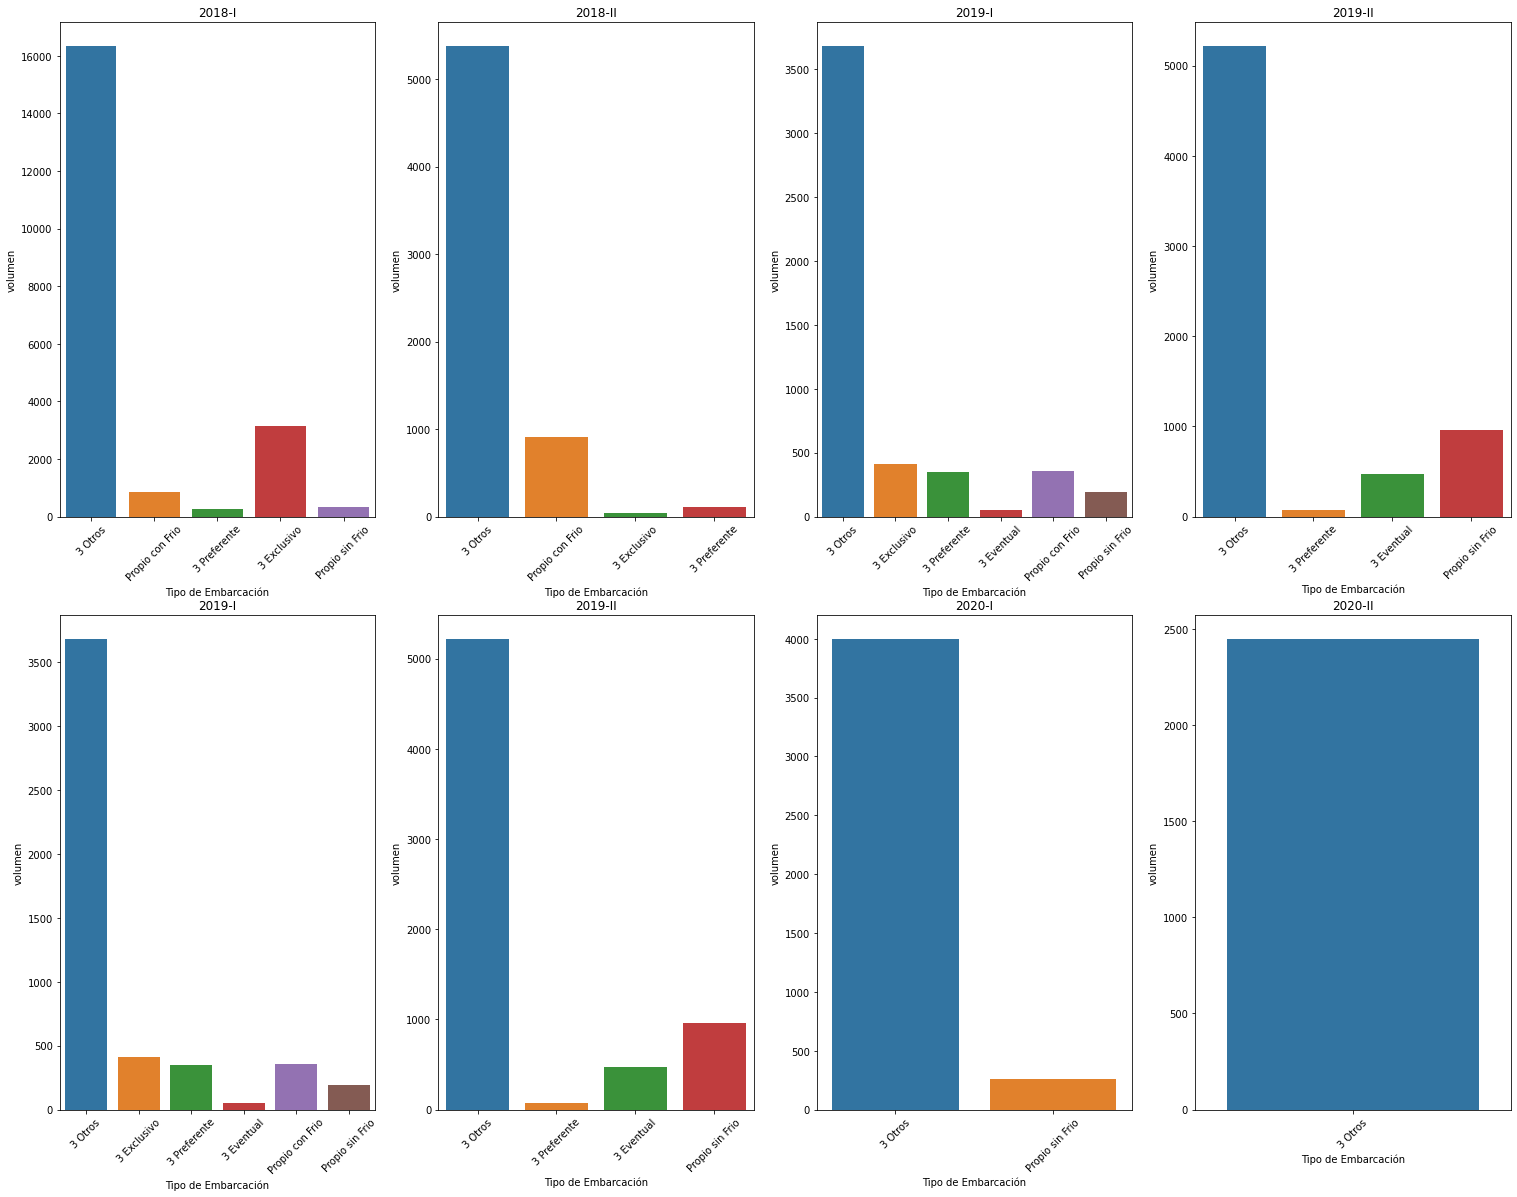

In [70]:

data = df[~mask_fin_tempor & ~mask_plant_notna]
# formatter = FuncFormatter(thousands)
fig, ax = plt.subplots(2, 4, figsize=(26, 20))
values = ['2018-I', '2018-II', '2019-I', '2019-II', '2020-I', '2020-II', '2021-I', '2021-II']
for i in range(2):
    for j in range(4):
        k = 2*i + j
        sns.barplot(ax=ax[i, j], data=data[data['temporada'] == values[k]], x='sort_tipo_embarc', y='volumen', estimator=sum, ci=None)
        # ax[i, j].yaxis.set_major_formatter(formatter)
        ax[i, j].set_title(values[k])
        # ax[i, j].bar_label(ax.containers[0])
        # ax[i, j].xticks(rotation=45)
        ax[i, j].tick_params(axis='x', labelrotation=45)
        ax[i, j].set_xlabel('Tipo de Embarcación')     

# fig.set_xticklabels(rotation=45)   
plt.show()

In [76]:
df.columns

Index(['CBOD', 'Embarc', 'Ind Propiedad', 'Orden_de_Prioridad', 'Tipo Tr',
       'Zona de Pesca', 'periodo', 'planta', 'sort_tipo_embarc',
       'fecha_produccion', 'id_embarcacion', 'volumen', 'temporada',
       'zona_de_pesca_id', 'Prioridad 1', 'Prioridad 2', 'Prioridad 3',
       'Prioridad 4', 'Prioridad 5', 'Prioridad 6', 'Prioridad 7',
       'Prioridad 8', 'planta_sugerida', 'y-m', 'rend'],
      dtype='object')

In [10]:
cols = ['temporada', 'planta']

mask = (df['planta_sugerida'].isna())
df_grouped = df[mask].groupby(cols, as_index=False)['volumen'].sum()

fig = px.histogram(df_grouped, x="temporada", y="volumen",
             color='planta', barmode='group',
            #  histfunc='avg',
             height=400)
fig.update_layout(
    template='plotly_dark'
)
fig.show()

In [69]:
cols = ['temporada', 'planta']

mask = (df['planta_sugerida'].isna())
df_grouped = df[mask].groupby(cols, as_index=False)['volumen'].sum()

fig = px.histogram(df_grouped, x="temporada", y="volumen",
             color='planta', barmode='group',
            #  histfunc='avg',
             height=400)
fig.update_layout(
    template='plotly_dark'
)
fig.show()

In [49]:
cols = ['temporada', 'planta']

mask = (df['planta_sugerida'].isna())
df_grouped = df[mask].groupby(cols, as_index=False)['volumen'].sum()

fig = px.histogram(df_grouped, x="temporada", y="volumen",
             color='planta', barmode='group',
            #  histfunc='avg',
             height=400)
fig.update_layout(
    template='plotly_dark'
)
fig.show()

In [13]:
cols = ['temporada', 'Zona de Pesca']

mask = (df['planta_sugerida'].isna())
df_grouped = df[mask].groupby(cols, as_index=False)['volumen'].sum()

fig = px.histogram(df_grouped, x="temporada", y="volumen",
             color='Zona de Pesca', barmode='group',
            #  histfunc='avg',
             height=400)
fig.show()

In [8]:
fig = px.bar(df, x="planta", y="volumen", color="planta",
  animation_frame="y-m", animation_group="Zona de Pesca", )
fig.show()

In [4]:
mask = df['Tipo Tr'] == 'Terceros'
all_vol = df[~mask].groupby(['temporada'])['volumen'].sum()
all_vol

temporada
2018-I     469620.265
2018-II    297338.834
2019-I     297424.235
2019-II    124465.300
2020-I     329101.035
2020-II    324051.300
2021-I     349471.877
2021-II    276032.875
Name: volumen, dtype: float64

In [5]:
mask = df['planta_sugerida'].isna()
togo_vol = df[mask].groupby(['temporada'])['volumen'].sum()
togo_vol

temporada
2018-I     23057.775
2018-II     8975.735
2019-I      4722.635
2019-II     6749.030
2020-I      4726.445
2020-II     8387.725
2021-I      1875.750
2021-II     1657.655
Name: volumen, dtype: float64

In [6]:
(togo_vol / all_vol) * 100

temporada
2018-I     4.909876
2018-II    3.018689
2019-I     1.587845
2019-II    5.422419
2020-I     1.436168
2020-II    2.588394
2021-I     0.536738
2021-II    0.600528
Name: volumen, dtype: float64

In [7]:
df[~mask].groupby(['fecha_produccion'])['volumen'].sum()

fecha_produccion
2018-04-07     8291.530
2018-04-08     8451.305
2018-04-09    11569.460
2018-04-10    10123.165
2018-04-11    12661.685
                ...    
2021-12-29     2361.570
2021-12-31     3915.770
2022-01-01      865.250
2022-01-02     1987.405
2022-01-03      511.485
Name: volumen, Length: 527, dtype: float64

In [6]:
6250 / 227

27.53303964757709

In [10]:
(6250 / 469620.26) * 100

1.3308625143216777

In [25]:
df['rend'].min()

0.005113999200005614

In [26]:
df.groupby(['y-m', 'Embarc', 'Zona de Pesca'], as_index=False).agg(
    volumen=('volumen', 'sum'),
    cantidad=('id', 'count'),
    rendimiento_prom=('rend', 'mean')
)

y-m    Embarc      Zona de Pesca  volumen  cantidad  rendimiento_prom
0       2018-1   TASA 22           Chimbote  133.385         1          0.404193
1       2018-1  TASA 314           Chimbote  149.390         1          0.424042
2       2018-1  TASA 315           Chimbote   81.505         1          0.222115
3       2018-1   TASA 41  Malabrigo/Chicama  189.070         1          0.383338
4       2018-1  TASA 411              Pisco   98.170         1          0.216219
...        ...       ...                ...      ...       ...               ...
11208  2022-52   TASA 56     Supe - Vegueta  160.265         1          0.320530
11209  2022-52   TASA 57     Supe - Vegueta  109.195         1          0.184317
11210  2022-52   TASA 58     Supe - Vegueta  206.755         1          0.350094
11211  2022-52   TASA 59     Supe - Vegueta  274.370         1          0.481347
11212  2022-52   TASA 71     Supe - Vegueta  283.915         1          0.388925

[11213 rows x 6 columns]

In [11]:
data = df[df['temporada'] == '2018-I']

fig = px.scatter(data, x="CBOD", y="volumen", animation_frame="y-m", animation_group="Embarc",
           size="cant", color="Zona de Pesca", #hover_name="country",
        #    log_x=True, 
           size_max=55, 
        #    range_x=[100,100000], range_y=[25,90]
           )

fig.show()

In [16]:
dff = px.data.gapminder()
fig = px.scatter(dff, x="gdpPercap", y="lifeExp", animation_frame="year", animation_group="country",
           size="pop", color="continent", hover_name="country",
           log_x=True, size_max=55, range_x=[100,100000], range_y=[25,90])
fig.show()

In [21]:
df.head()

id    CBOD        Embarc Ind Propiedad  Orden_de_Prioridad   Tipo Tr Zona de Pesca  id_zona_de_pesca  periodo sort_tipo_embarc temporada fecha_produccion  Embarcacion_id  volumen Prioridad 1 Prioridad 2 Prioridad 3 Prioridad 4 Prioridad 5 Prioridad 6 Prioridad 7 Prioridad 8 planta_sugerida      y-m
0   0  388.94       COQUI X       Tercera                 2.0  Terceros       Pisco S              14.0     2018      3 Exclusivo    2018-I       2018-04-07           28225   38.980     Pisco S     Pisco N         NaN         NaN         NaN         NaN         NaN         NaN         Pisco S  2018-14
1   1  353.77     COQUI XII       Tercera                 3.0  Terceros       Pisco S              14.0     2018      3 Exclusivo    2018-I       2018-04-07           11074   41.950     Pisco S     Pisco N         NaN         NaN         NaN         NaN         NaN         NaN         Pisco S  2018-14
2   2  339.00  SAN JUDAS II       Tercera                 5.0  Terceros       Pisco N              13.0     2018      3 Exclusivo    2018-I       2018-04-07           41816  219.020     Pisco N     Pisco S         NaN         NaN         NaN         NaN         NaN         NaN         Pisco N  2018-14
3   3  335.08      COQUI IX       Tercera                 6.0  Terceros       Pisco S              14.0     2018      3 Exclusivo    2018-I       2018-04-07           11071   33.375     Pisco S     Pisco N         NaN         NaN         NaN         NaN         NaN         NaN         Pisco S  2018-14
4   4  296.85     MACABI 10       Tercera                11.0  Terceros      Chimbote               3.0     2018      3 Exclusivo    2018-I       2018-04-07           29416   31.935    Chimbote     Samanco         NaN         NaN         NaN         NaN         NaN         NaN        Chimbote  2018-14

In [36]:
df.groupby(['Zona de Pesca', 'sort_tipo_embarc','y-m'], as_index=False).agg(
    volumen_prom=('volumen', 'mean'),
    volumen_tot=('volumen', 'sum'),
    cantidad=('Embarc', 'count'),
    rendimiento_prom=('rend', 'mean')
)

Zona de Pesca sort_tipo_embarc      y-m  volumen_prom  volumen_tot  cantidad  rendimiento_prom
0           Callao       3 Eventual  2019-18      14.74500       14.745         1          0.185542
1           Callao       3 Eventual  2019-19      59.67200      298.360         5          0.863433
2           Callao       3 Eventual  2019-49      78.38500      156.770         2          0.544076
3           Callao       3 Eventual  2020-22     114.90750      459.630         4          0.797581
4           Callao       3 Eventual  2020-25      72.60500       72.605         1          0.506417
...            ...              ...      ...           ...          ...       ...               ...
1440       Vegueta     3 Preferente  2021-22      63.39800      316.990         5          0.449560
1441       Vegueta     3 Preferente  2021-23      48.89625      195.585         4          0.319774
1442       Vegueta     3 Preferente  2021-47      72.66700      363.335         5          0.570161
1443       Vegueta     3 Preferente  2021-48      50.34500       50.345         1          0.395018
1444       Vegueta     3 Preferente  2021-50      73.22125      292.885         4          0.666982

[1445 rows x 7 columns]

In [17]:
dff.head()

country continent  year  lifeExp       pop   gdpPercap iso_alpha  iso_num
0  Afghanistan      Asia  1952   28.801   8425333  779.445314       AFG        4
1  Afghanistan      Asia  1957   30.332   9240934  820.853030       AFG        4
2  Afghanistan      Asia  1962   31.997  10267083  853.100710       AFG        4
3  Afghanistan      Asia  1967   34.020  11537966  836.197138       AFG        4
4  Afghanistan      Asia  1972   36.088  13079460  739.981106       AFG        4

In [10]:
df[name_tempo].value_counts(dropna=False)

2018-I     4589
2020-II    4438
2021-I     3403
2019-I     3276
2018-II    2817
2020-I     2785
2019-II    2562
2021-II    2553
Name: temporada, dtype: int64

In [19]:
name_dif_min = 'diferencias'
df[name_dif_min].describe(percentiles=np.arange(0, 1, 0.01))

count     26423.000000
mean         74.498732
std        2747.033486
min           0.000000
0%            0.000000
             ...      
96%           0.000000
97%           0.000000
98%           0.000000
99%        1440.000000
max      207360.000000
Name: dif_minutes, Length: 105, dtype: float64

In [11]:
mask = df['planta_sugerida'].notna()
df.loc[mask, 'volumen'].sum()

3662968.1509999996

In [8]:
757 / len(df.index)

0.028649282821784052

In [3]:
path = 'outputs/'

file = 'data_test_last_cala.csv'

df_adic = pd.read_csv(path + file)
df_adic.head()

zona_de_pesca_id  id_embarcacion  2018-04-07 00:00:00  2018-04-08 00:00:00  2018-04-09 00:00:00  2018-04-10 00:00:00  2018-04-11 00:00:00  2018-04-12 00:00:00  2018-04-13 00:00:00  2018-04-14 00:00:00  2018-04-15 00:00:00  2018-04-16 00:00:00  2018-04-17 00:00:00  2018-04-18 00:00:00  2018-04-19 00:00:00  2018-04-20 00:00:00  2018-04-21 00:00:00  2018-04-22 00:00:00  2018-04-23 00:00:00  2018-04-24 00:00:00  2018-04-25 00:00:00  2018-04-26 00:00:00  2018-04-27 00:00:00  2018-04-28 00:00:00  2018-04-29 00:00:00  2018-04-30 00:00:00  2018-05-01 00:00:00  2018-05-02 00:00:00  2018-05-03 00:00:00  2018-05-04 00:00:00  2018-05-05 00:00:00  2018-05-06 00:00:00  2018-05-07 00:00:00  2018-05-08 00:00:00  2018-05-09 00:00:00  2018-05-10 00:00:00  2018-05-11 00:00:00  2018-05-12 00:00:00  2018-05-13 00:00:00  2018-05-14 00:00:00  2018-05-15 00:00:00  2018-05-16 00:00:00  2018-05-17 00:00:00  2018-05-18 00:00:00  2018-05-19 00:00:00  2018-05-20 00:00:00  2018-05-21 00:00:00  2018-05-22 00:00:00  2018-05-23 00:00:00  2018-05-24 00:00:00  2018-05-25 00:00:00  2018-05-26 00:00:00  2018-05-27 00:00:00  2018-05-28 00:00:00  2018-05-29 00:00:00  2018-05-30 00:00:00  2018-05-31 00:00:00  2018-06-01 00:00:00  2018-06-02 00:00:00  2018-06-03 00:00:00  2018-06-04 00:00:00  2018-06-05 00:00:00  2018-06-06 00:00:00  2018-06-07 00:00:00  2018-06-08 00:00:00  2018-06-09 00:00:00  2018-06-11 00:00:00  2018-06-16 00:00:00  2018-06-17 00:00:00  2018-06-19 00:00:00  2018-06-20 00:00:00  2018-06-21 00:00:00     CBOD ult_dia_cala  cant_dias_cala dias_faltantes
0                 2           10201                14.25               22.975                8.625              330.003           330.003000             211.8125              330.003               65.865            330.00300              205.765              330.003              330.003             330.0030               232.76           330.003000             244.3175              314.226           330.003000                67.43               11.045             219.0575               203.68           254.271667            325.07375              258.997             330.0030           330.003000           310.803125           330.003000           330.003000             330.0030               163.09              238.183           160.817857            282.26625            166.17625               33.055               12.655                 34.9               47.925               56.485               299.37                59.41               19.805                61.63               11.905                11.63                31.75               63.775              281.215             260.5125              111.905                2.905              330.003               83.740                36.29                37.06              330.003              284.725              286.605               140.53              175.885              172.695              175.925                77.25              226.455              171.785              330.003              181.695               78.635  330.003   2018-05-31               1        21 days
1                 2           10614                14.25               22.975                8.625              342.735           341.219167             211.8125              425.545               65.865            341.53500              205.765              364.605              335.990             344.8700               232.76           359.930000             244.3175              314.226           418.601667                67.43               11.045             219.0575               203.68           254.271667            325.07375              258.997             368.3575           407.290833           310.803125           339.675625           366.526875             380.7075               163.09              238.183           247.000000            282.26625            125.72000               33.055               12.655                 34.9               47.925          

In [14]:
df_adic['dias_faltantes'] = df_adic['dias_faltantes'].str[0:2].astype(int)
df_adic.head()

zona_de_pesca_id  id_embarcacion  2018-04-07 00:00:00  2018-04-08 00:00:00  2018-04-09 00:00:00  2018-04-10 00:00:00  2018-04-11 00:00:00  2018-04-12 00:00:00  2018-04-13 00:00:00  2018-04-14 00:00:00  2018-04-15 00:00:00  2018-04-16 00:00:00  2018-04-17 00:00:00  2018-04-18 00:00:00  2018-04-19 00:00:00  2018-04-20 00:00:00  2018-04-21 00:00:00  2018-04-22 00:00:00  2018-04-23 00:00:00  2018-04-24 00:00:00  2018-04-25 00:00:00  2018-04-26 00:00:00  2018-04-27 00:00:00  2018-04-28 00:00:00  2018-04-29 00:00:00  2018-04-30 00:00:00  2018-05-01 00:00:00  2018-05-02 00:00:00  2018-05-03 00:00:00  2018-05-04 00:00:00  2018-05-05 00:00:00  2018-05-06 00:00:00  2018-05-07 00:00:00  2018-05-08 00:00:00  2018-05-09 00:00:00  2018-05-10 00:00:00  2018-05-11 00:00:00  2018-05-12 00:00:00  2018-05-13 00:00:00  2018-05-14 00:00:00  2018-05-15 00:00:00  2018-05-16 00:00:00  2018-05-17 00:00:00  2018-05-18 00:00:00  2018-05-19 00:00:00  2018-05-20 00:00:00  2018-05-21 00:00:00  2018-05-22 00:00:00  2018-05-23 00:00:00  2018-05-24 00:00:00  2018-05-25 00:00:00  2018-05-26 00:00:00  2018-05-27 00:00:00  2018-05-28 00:00:00  2018-05-29 00:00:00  2018-05-30 00:00:00  2018-05-31 00:00:00  2018-06-01 00:00:00  2018-06-02 00:00:00  2018-06-03 00:00:00  2018-06-04 00:00:00  2018-06-05 00:00:00  2018-06-06 00:00:00  2018-06-07 00:00:00  2018-06-08 00:00:00  2018-06-09 00:00:00  2018-06-11 00:00:00  2018-06-16 00:00:00  2018-06-17 00:00:00  2018-06-19 00:00:00  2018-06-20 00:00:00  2018-06-21 00:00:00     CBOD ult_dia_cala  cant_dias_cala  dias_faltantes
0                 2           10201                14.25               22.975                8.625              330.003           330.003000             211.8125              330.003               65.865            330.00300              205.765              330.003              330.003             330.0030               232.76           330.003000             244.3175              314.226           330.003000                67.43               11.045             219.0575               203.68           254.271667            325.07375              258.997             330.0030           330.003000           310.803125           330.003000           330.003000             330.0030               163.09              238.183           160.817857            282.26625            166.17625               33.055               12.655                 34.9               47.925               56.485               299.37                59.41               19.805                61.63               11.905                11.63                31.75               63.775              281.215             260.5125              111.905                2.905              330.003               83.740                36.29                37.06              330.003              284.725              286.605               140.53              175.885              172.695              175.925                77.25              226.455              171.785              330.003              181.695               78.635  330.003   2018-05-31               1              21
1                 2           10614                14.25               22.975                8.625              342.735           341.219167             211.8125              425.545               65.865            341.53500              205.765              364.605              335.990             344.8700               232.76           359.930000             244.3175              314.226           418.601667                67.43               11.045             219.0575               203.68           254.271667            325.07375              258.997             368.3575           407.290833           310.803125           339.675625           366.526875             380.7075               163.09              238.183           247.000000            282.26625            125.72000               33.055               12.655                 34.9               47.925        

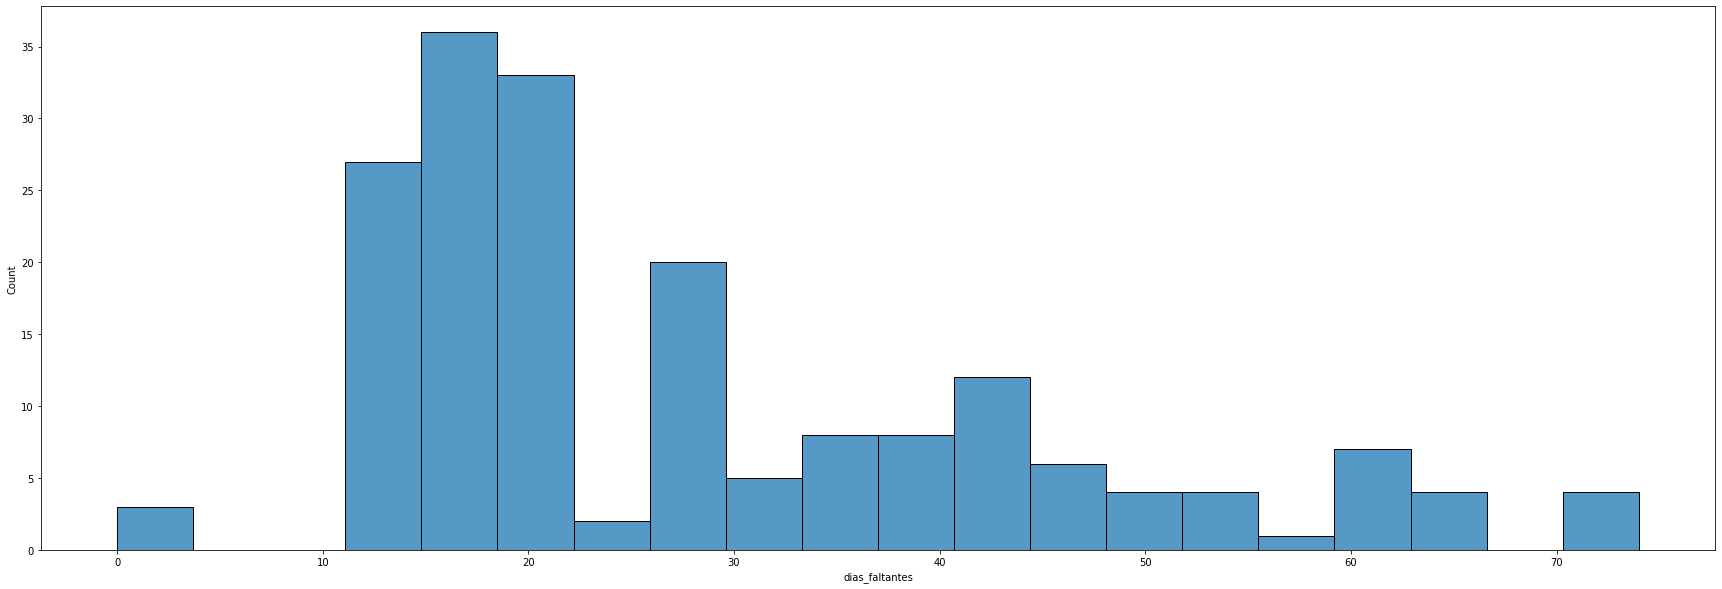

In [60]:
from matplotlib.pyplot import figure

figure(figsize=(30, 10))

sns.histplot(data=df_adic, x='dias_faltantes', bins=20)
plt.show()

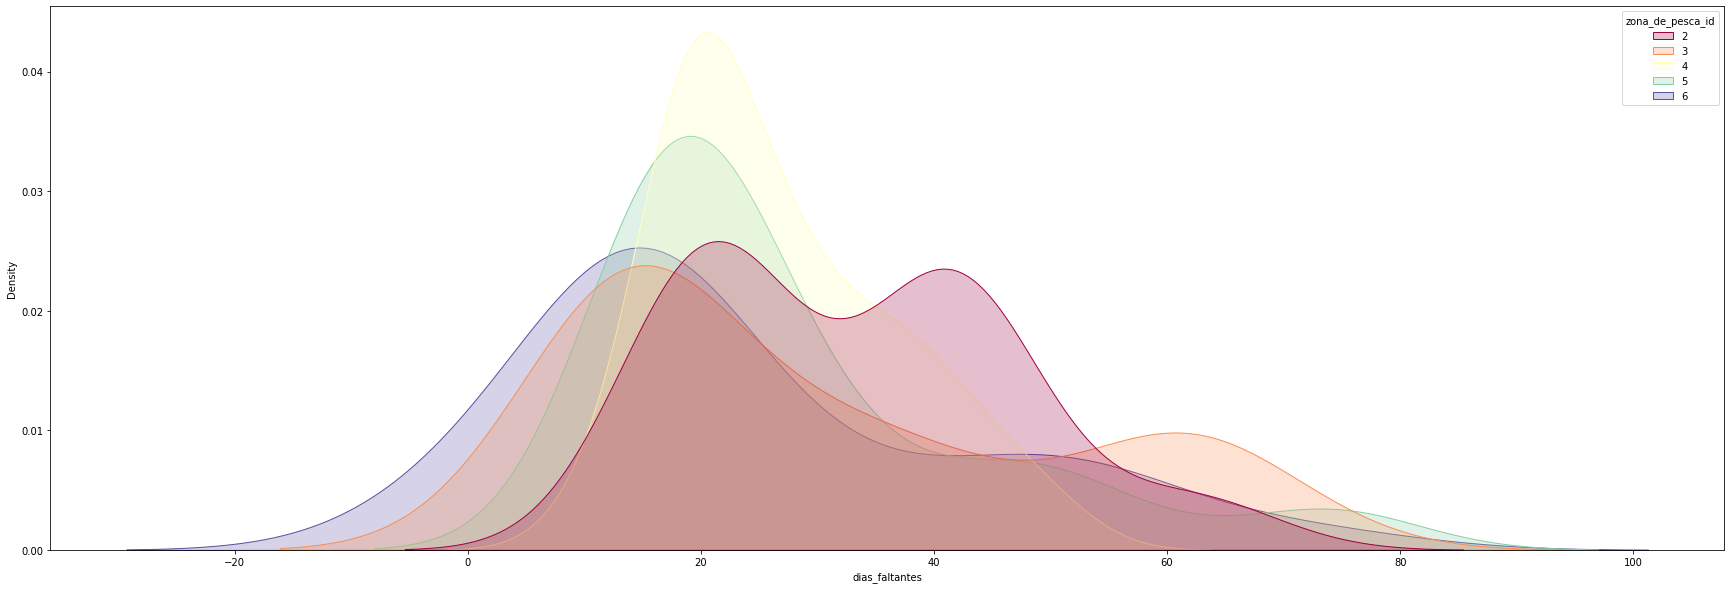

In [63]:
from matplotlib.pyplot import figure

figure(figsize=(30, 10))

sns.kdeplot(data=df_adic, x='dias_faltantes', hue='zona_de_pesca_id', palette="Spectral", fill=True, common_norm=False)
plt.show()